# Multiclass SVM Tutorial  
Tutorial Link: https://towardsdatascience.com/implement-multiclass-svm-from-scratch-in-python-b141e43dc084

**Hard Margin SVM**  
The goal in SVM is to fit the hyperplane that would attain the maximum margin (distance from the closest points from in the two classes). A hyperplane denotes the decision boundary line, wherein data points fall either side. In order to achieve this you must solve the dual optimization problem.  

**Soft Margin SVM**  
The soft margin SVM adapts the optimization problem by introducting a C constant (hyperparameter) that controls the strictness of the margin. The optimization problem:  
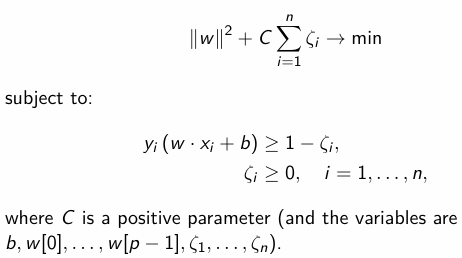  

**Kernel Soft Margin SVM K(x,x')**  
- Linear  
- Polynomial  
- Gaussian (Radial Basis Function)  

In [1]:
import numpy as np # for basic operations over arrays
from scipy.spatial import distance # to compute the Gaussian kernel
import cvxopt # to solve dual optimization problem
import copy # to copy numpy arrays

In [2]:
class SVM:
    linear = lambda x, xprime, c = 0: x @ xprime.T
    polynomial = lambda x, xprime, Q = 5: (1 + x @ xprime.T)**Q
    rbf = lambda x, xprime, gamma = 10: np.exp(- gamma * distance.cdist(x, xprime, 'sqeuclidean'))
    kernel_funcs = {'linear': linear, 'polynomial': polynomial, 'rbf': rbf}
    
    def __init__(self, kernel='rbf', C=1, k=2):
        # set the hyperparameters
        self.kernel_str = kernel
        self.kernel = SVM.kernel_funcs[kernel]
        self.C = C # regularization parameter
        self.k = k # kernel parameter
        
        # training data and support vectors
        self.X, y = None, None
        self.alphas = None
        
        # for multi-class classification
        self.multiclass = False
        self.clfs = []

In [3]:
# This line of code allows us to add methods to class in different cells
SVMClass = lambda func: setattr(SVM, func.__name__, func) or func

Fitting the SVM correponds to finding the supoort vector *alpha* for each point by solving the dual optimization problem:  
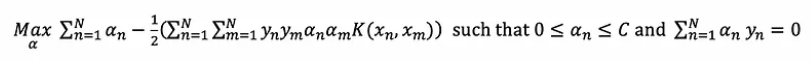  

Let alpha be a variable column vector ($\alpha_{1},\alpha_{2},...,\alpha_{N}$).T and let y be a constant column vector for the labels ($y_{1},y_{2},...,y_{N}$).T and let K be a constant matrix where K[n,m] computes the kernal at ($x_{n},x_{m}$). We can then rewrite the dual optimization problem as:  
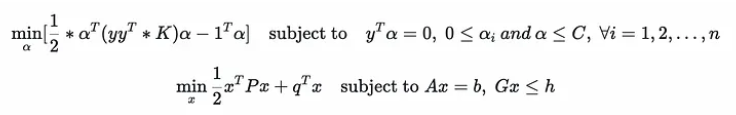

In [4]:
@SVMClass
def fit(self, X, y, eval_train=False):
    # if more than two unique labels, call the multiclass version
    if len(np.unique(y)) > 2:
        self.multiclass = True
        return self.multi_fit(X, y, eval_train)
    
    # if labels given in {0,1} change it to {-1,1}
    if set(np.unique(y)) == {0, 1}: y[y==0] = -1
    
    # ensure y is a Nx1 column vecotr (needed by CVXOPT)
    self.y = y.reshape(-1, 1).astype(np.double) # Has to be a column vector
    self.X = X
    N = X.shape[0] # Number of points
    
    # compute the kernel over all possible pairs of (x, x') in the data
    # by Numpy's vectorization this yields the matrix K
    self.K = self.kernel(X, X, self.k)
    
    ### Set up optimization parameters
    # For 1/2 x^T P x + q^T x
    P = cvxopt.matrix(self.y @ self.y.T * self.K)
    q = cvxopt.matrix(-np.ones((N, 1)))
    
    # For Ax = b
    A = cvxopt.matrix(self.y.T)
    b = cvxopt.matrix(np.zeros(1))
    
    # For Gx <= h
    G = cvxopt.matrix(np.vstack((-np.identity(N), np.identity(N))))
    h = cvxopt.matrix(np.vstack((np.zeros((N,1)), np.ones((N,1)) * self.C)))
    
    # Solve 
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    self.alphas = np.array(sol['x']) # our solution
    
    # a Boolean array that flags points which are support vectors
    self.is_sv = ((self.alphas-1e-3 > 0)&(self.alphas <= self.C-1e-3)).squeeze() # alpha <= 1e-3 is approximately zero
    # an index of some margin support vector
    self.margin_sv = np.argmax((0 < self.alphas-1e-3)&(self.alphas < self.C-1e-3))
    
    if eval_train:
        print(f'Finished training with accuracy {self.evaluate(X,y)}')
        

### Prediction  
The prediction equation is:  
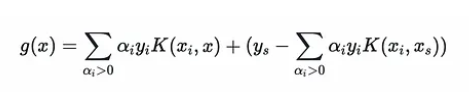

In [5]:
@SVMClass
def predict(self, X_t):
    if self.multiclass: return self.multi_predict(X_t)
    # compute (x_s, y_s)
    x_s, y_s = self.X[self.margin_sv, np.newaxis], self.y[self.margin_sv]
    # find support vectors
    alphas, y, X= self.alphas[self.is_sv], self.y[self.is_sv], self.X[self.is_sv]
    # compute the second term
    b = y_s - np.sum(alphas * y * self.kernel(X, x_s, self.k), axis=0)
    # compute the score
    score = np.sum(alphas * y * self.kernel(X, X_t, self.k), axis=0) + b
    return np.sign(score).astype(int), score

In [21]:
@SVMClass
def evaluate(self, X, y):
    if self.multiclass: return self.multi_evaluate(X,y)
    outputs, _ = self.predict(X)
    accuracy = np.sum(outputs == y) / len(y)
    return round(accuracy, 2), outputs

### Testing the implementation

In [22]:
from sklearn.datasets import make_classification
import numpy as np

# Load the dataset
np.random.seed(1)
X, y = make_classification(n_samples=2500, n_features=5, n_redundant=0, n_informative=5, n_classes=2, class_sep=0.3)

# Test Implemented SVM
svm = SVM(kernel='rbf', k=1)
svm.fit(X, y, eval_train=True)
print(f'Accuracy: {svm.evaluate(X,y)}')
#y_pred, _ = svm.predict(X)
#print(f'Accuracy: {np.sum(y==y_pred)/y.shape[0]}')

# Test with scikit
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1, gamma=1)
clf.fit(X, y)
y_pred = clf.predict(X)
print(f'Accuracy: {np.sum(y==y_pred)/y.shape[0]}')

Finished training with accuracy (0.81, array([-1,  1, -1, ...,  1, -1,  1]))
Accuracy: (0.81, array([-1,  1, -1, ...,  1, -1,  1]))
Accuracy: 0.9108


### Multiclass Fitting  
To generalize the model to multiclass, over k classes. We train a binary SVM classifier for each class present where we loop on each class and relabel points belonging to it into +1 and points representing other classes as -1.

In [8]:
@SVMClass 
def multi_fit(self, X, y, eval_train=False):
    self.k = len(np.unique(y)) # Number of classes
    # for each pair of classes
    for i in range(self.k):
        # get the data for the pair
        Xs, Ys = X, copy.copy(y)
        # Change the labels to -1 and 1
        Ys[Ys!=i], Ys[Ys==i] = -1, +1
        #fit the classifier
        clf = SVM(kernel=self.kernel_str,C=self.C, k=self.k)
        clf.fit(Xs, Ys)
        # save the classifier
        self.clfs.append(clf)
    if eval_train:
        print(f'Finished training with accuracy {self.evaluate(X, y)}')

### Multiclass Predictions  
To perform prediction, we choose the corresponding classifier which is most confident (has the highest score).

In [9]:
@SVMClass
def multi_predict(self, X):
    # get the predictions from all classifiers
    N = X.shape[0]
    preds = np.zeros((N, self.k))
    for i, clf in enumerate(self.clfs):
        _, preds[:, i] = clf.predict(X)
    
    # get the argmax and the corresponding score
    return np.argmax(preds, axis=1), np.max(preds, axis=1)

In [20]:
@SVMClass
def multi_evaluate(self, X, y):
    outputs, _ = self.multi_predict(X)
    accuracy = np.sum(outputs == y) / len(y)
    return round(accuracy, 2) , outputs

In [23]:
from sklearn.datasets import make_classification 
import numpy as np

# Load the dataset 
np.random.seed(1)
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_classes=4, n_clusters_per_class=1, class_sep=0.3)

#Test SVM
svm = SVM(kernel='rbf', k=4)
svm.fit(X, y, eval_train=True)
print(f'Accuracy: {svm.evaluate(X,y)}')
#y_pred = svm.predict(X)
#print(f'Accuracy: {np.sum(y==y_pred)/y.shape[0]}')

# Test with scikit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(kernel='rbf', C=1, gamma=4)).fit(X,y)
y_pred = clf.predict(X)
print(f'Accuracy: {sum(y==y_pred)/y.shape[0]}')

Finished training with accuracy (0.55, array([3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0,
       3, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 0, 3, 2, 0,
       3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 2, 0, 3, 0,
       3, 0, 0, 0, 0, 3, 2, 3, 0, 3, 3, 0, 3, 3, 0, 2, 3, 3, 0, 2, 3, 0,
       0, 0, 0, 0, 3, 0, 3, 2, 3, 1, 3, 3, 3, 0, 0, 3, 0, 2, 3, 0, 0, 0,
       2, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3,
       2, 2, 0, 3, 0, 3, 3, 2, 0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 0,
       0, 0, 2, 0, 0, 0, 3, 0, 2, 3, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 3, 3,
       3, 0, 0, 3, 3, 3, 0, 3, 1, 3, 0, 3, 0, 0, 3, 3, 0, 0, 2, 0, 3, 0,
       0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 2, 3, 0, 0, 0, 0, 3, 0, 0,
       3, 0, 3, 0, 3, 3, 0, 0, 3, 2, 0, 2, 0, 2, 0, 0, 0, 2, 3, 3, 2, 0,
       3, 3, 0, 3, 0, 3, 0, 2, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 2, 3, 0,
       0, 2,

In [30]:
y

array([3, 0, 1, 1, 1, 0, 1, 3, 1, 0, 3, 2, 0, 3, 0, 0, 1, 1, 2, 0, 2, 0,
       2, 1, 2, 3, 1, 0, 3, 2, 1, 3, 1, 2, 1, 3, 1, 0, 1, 2, 0, 1, 2, 2,
       3, 1, 1, 0, 3, 1, 1, 0, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 0, 3, 1,
       3, 1, 1, 1, 3, 3, 2, 3, 2, 1, 2, 0, 3, 3, 2, 2, 2, 3, 0, 2, 2, 1,
       0, 1, 0, 1, 3, 1, 1, 2, 1, 1, 2, 2, 3, 1, 0, 1, 2, 2, 1, 2, 0, 0,
       3, 3, 0, 3, 2, 1, 3, 1, 3, 0, 3, 0, 1, 2, 0, 1, 1, 3, 3, 1, 0, 1,
       2, 2, 0, 2, 0, 3, 3, 3, 0, 2, 0, 0, 2, 3, 3, 0, 1, 0, 3, 3, 3, 0,
       1, 1, 2, 2, 2, 1, 0, 0, 2, 2, 0, 3, 0, 1, 1, 0, 0, 1, 1, 0, 3, 2,
       3, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 2, 2, 0, 3, 0,
       0, 3, 0, 2, 3, 2, 3, 2, 3, 0, 3, 3, 0, 0, 1, 2, 3, 2, 0, 0, 1, 1,
       3, 2, 0, 3, 1, 3, 2, 1, 2, 3, 2, 2, 3, 2, 3, 0, 1, 0, 2, 1, 0, 2,
       3, 0, 1, 1, 3, 0, 0, 1, 3, 2, 2, 2, 1, 2, 2, 0, 0, 2, 1, 3, 2, 1,
       3, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 0, 1, 3, 3, 0, 3, 3, 1,
       0, 2, 0, 3, 3, 0, 0, 2, 1, 0, 3, 2, 0, 3, 3,

In [32]:
y[1]

0

In [64]:
X[y==0][:,0]

array([ 1.36202666e-01, -7.89892808e-02,  2.94197239e-01, -5.04108167e-01,
       -1.60735320e-02, -7.50565842e-01,  3.06538081e-01, -1.44428197e-01,
        3.46338610e-01,  3.81316249e-01, -6.61915978e-01, -2.63818684e-01,
       -9.46914704e-01, -6.42547717e-01, -8.00324188e-01,  6.34739662e-01,
       -2.96648252e-01,  3.74916746e-02, -6.91217944e-02, -6.87766014e-01,
       -9.12373435e-01,  1.79294671e-01, -9.96242905e-01,  2.74156003e-01,
       -5.45427839e-01, -1.32957636e+00, -1.13299401e+00,  1.44351826e-01,
       -1.22725473e+00, -7.49345593e-01, -8.33889703e-01, -4.59834247e-01,
       -6.14081664e-01, -7.66479229e-01, -4.50589844e-01, -3.85085375e-02,
       -1.42064036e-01,  3.32842523e-01,  2.70416429e-01, -8.82250654e-01,
       -1.37463628e+00, -7.06053883e-01,  6.21810842e-01, -1.66365068e-01,
       -5.40890014e-01, -1.67817820e-01, -4.53972122e-01, -5.96524563e-01,
       -6.82718336e-01, -5.95775635e-01, -2.43693119e-01, -7.99262773e-01,
       -2.49637980e-01, -

In [23]:
import matplotlib.pyplot as plt

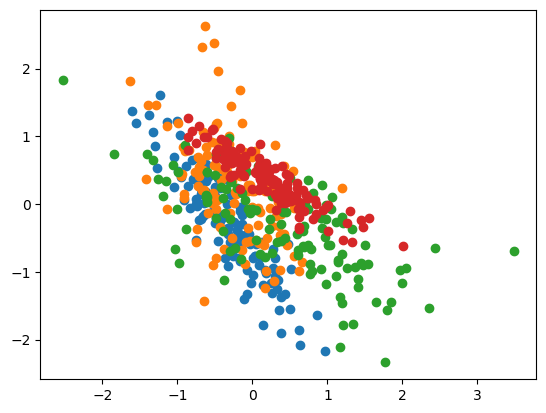

In [65]:
fig, ax = plt.subplots()
for i in range(0,5):
    ax.scatter(X[y==i][:,0],X[y==i][:,1])
plt.show()

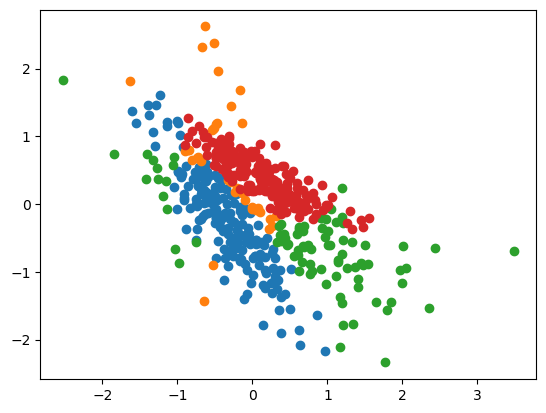

In [66]:
fig, ax = plt.subplots()
for i in range(0,5):
    ax.scatter(X[y_pred==i][:,0],X[y_pred==i][:,1])
plt.show()

In [12]:
#Test SVM (Linear)
svm = SVM(kernel='linear', k=4)
svm.fit(X, y, eval_train=True)

y_pred = svm.predict(X)
print(f'Accuracy: {np.sum(y==y_pred)/y.shape[0]}')

clf = OneVsRestClassifier(SVC(kernel='linear', C=1, gamma=4)).fit(X,y)
y_pred = clf.predict(X)
print(f'Accuracy: {sum(y==y_pred)/y.shape[0]}')

Finished training with accuracy 0.19
Accuracy: 0.194
Accuracy: 0.524


In [14]:
#Test SVM (Linear)
svm = SVM(kernel='polynomial', k=4)
svm.fit(X, y, eval_train=True)

y_pred = svm.predict(X)
print(f'Accuracy: {np.sum(y==y_pred)/y.shape[0]}')

clf = OneVsRestClassifier(SVC(kernel='poly', C=1, gamma=4)).fit(X,y)
y_pred = clf.predict(X)
print(f'Accuracy: {sum(y==y_pred)/y.shape[0]}')

Finished training with accuracy 0.32
Accuracy: 0.316
Accuracy: 0.482
